<a href="https://colab.research.google.com/github/banno-0720/learning_TensorFlow/blob/main/Human_Emotions_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import time
import random
from google.colab import files
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.cm as cm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
from google.colab import drive

In [ ]:
CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["angry", "happy", "sad"],
}

# Data Management

## Data Downloading

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od

In [ ]:
od.download("https://www.kaggle.com/datasets/muhammadhananasghar/human-emotions-datasethes")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: himanshugoyal2004
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/muhammadhananasghar/human-emotions-datasethes


100%|██████████| 309M/309M [00:01<00:00, 177MB/s]


In [ ]:
train_directory = "/content/human-emotions-datasethes/Emotions Dataset/Emotions Dataset/train"
val_directory = "/content/human-emotions-datasethes/Emotions Dataset/Emotions Dataset/test"
CLASS_NAMES = ["angry", "happy", "sad"]

## Dataset Loading

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 6799 files belonging to 3 classes.


In [ ]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=1,#CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 2278 files belonging to 3 classes.


In [ ]:
# for i in val_dataset.take(1):
#   print(i)

## Dataset Visualization

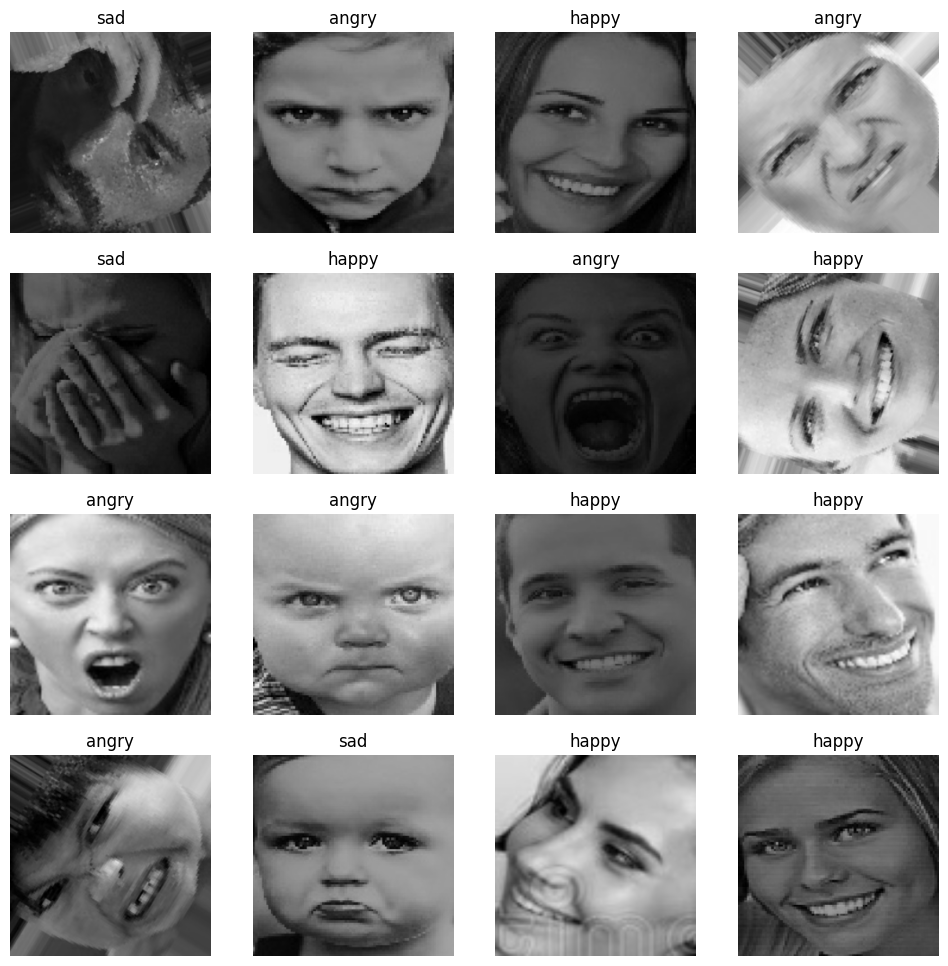

In [ ]:
plt.figure(figsize = (12,12))

for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    plt.title(CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis = 0).numpy()])
    plt.axis("off")

## Data Augmentation

In [ ]:
### tf.keras.layer augment
augment_layers = tf.keras.Sequential([
  RandomRotation(factor = (-0.025, 0.025)),
  RandomFlip(mode='horizontal',),
  RandomContrast(factor=0.1),
])

In [ ]:
def augment_layer(image, label):
  return augment_layers(image, training = True), label

### Cutmix Augmentation

In [ ]:
def box(lamda):

  r_x = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)

  r_w = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)
  r_h = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)

  r_x = tf.clip_by_value(r_x - r_w//2, 0, CONFIGURATION["IM_SIZE"])
  r_y = tf.clip_by_value(r_y - r_h//2, 0, CONFIGURATION["IM_SIZE"])

  x_b_r = tf.clip_by_value(r_x + r_w//2, 0, CONFIGURATION["IM_SIZE"])
  y_b_r = tf.clip_by_value(r_y + r_h//2, 0, CONFIGURATION["IM_SIZE"])

  r_w = x_b_r - r_x
  if(r_w == 0):
    r_w  = 1

  r_h = y_b_r - r_y
  if(r_h == 0):
    r_h = 1

  return r_y, r_x, r_h, r_w

In [ ]:
def cutmix(train_dataset_1, train_dataset_2):
  (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(2,2)
  lamda = lamda.sample(1)[0]

  r_y, r_x, r_h, r_w = box(lamda)
  crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  image = image_1 - pad_1 + pad_2

  lamda = tf.cast(1- (r_w*r_h)/(CONFIGURATION["IM_SIZE"]*CONFIGURATION["IM_SIZE"]), dtype = tf.float32)
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)

  return image, label

## Dataset Preparation

In [ ]:
# train_dataset_1 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
# train_dataset_2 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)

# mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

In [ ]:

# training_dataset = (
#     mixed_dataset
#     .map(cutmix, num_parallel_calls = tf.data.AUTOTUNE)
#     .prefetch(tf.data.AUTOTUNE)
# )

In [ ]:
training_dataset = (
    train_dataset
    .map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)


In [ ]:
validation_dataset = (
    val_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
resize_rescale_layers = tf.keras.Sequential([
       Resizing(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
       Rescaling(1./255),
])

In [ ]:
training_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [ ]:
validation_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

# Modeling

## Lenet

In [ ]:
lenet_model = tf.keras.Sequential(
    [
    InputLayer(input_shape = (None, None, 3), ),

    resize_rescale_layers,

    Conv2D(filters = CONFIGURATION["N_FILTERS"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], strides = CONFIGURATION["N_STRIDES"] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"] ),

    Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),

    Flatten(),

    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),

    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

])

lenet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 6)       168       
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 6)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 6)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 16)     

## ResNet34

### CustomConv2D

In [ ]:
class CustomConv2D(Layer):
  def __init__(self, n_filters, kernel_size, n_strides, padding = 'valid'):
    super(CustomConv2D, self).__init__(name = 'custom_conv2d')

    self.conv = Conv2D(
        filters = n_filters,
        kernel_size = kernel_size,
        activation = 'relu',
        strides = n_strides,
        padding = padding)

    self.batch_norm = BatchNormalization()

  def call(self, x, training = True):

    x = self.conv(x)
    x = self.batch_norm(x, training)

    return x

### Residual Block

In [ ]:
class ResidualBlock(Layer):
  def __init__(self, n_channels, n_strides = 1):
    super(ResidualBlock, self).__init__(name = 'res_block')

    self.dotted = (n_strides != 1)

    self.custom_conv_1 = CustomConv2D(n_channels, 3, n_strides, padding = "same")
    self.custom_conv_2 = CustomConv2D(n_channels, 3, 1, padding = "same")

    self.activation = Activation('relu')

    if self.dotted:
      self.custom_conv_3 = CustomConv2D(n_channels, 1, n_strides)

  def call(self, input, training):

    x = self.custom_conv_1(input, training)
    x = self.custom_conv_2(x, training)

    if self.dotted:
      x_add = self.custom_conv_3(input, training)
      x_add = Add()([x, x_add])
    else:
      x_add = Add()([x, input])

    return self.activation(x_add)


### Complete Network

In [ ]:
class ResNet34(Model):
  def __init__(self,):
    super(ResNet34, self).__init__(name = 'resnet_34')

    self.conv_1 = CustomConv2D(64, 7, 2, padding = 'same')
    self.max_pool = MaxPooling2D(3,2)

    self.conv_2_1 = ResidualBlock(64)
    self.conv_2_2 = ResidualBlock(64)
    self.conv_2_3 = ResidualBlock(64)

    self.conv_3_1 = ResidualBlock(128, 2)
    self.conv_3_2 = ResidualBlock(128)
    self.conv_3_3 = ResidualBlock(128)
    self.conv_3_4 = ResidualBlock(128)

    self.conv_4_1 = ResidualBlock(256, 2)
    self.conv_4_2 = ResidualBlock(256)
    self.conv_4_3 = ResidualBlock(256)
    self.conv_4_4 = ResidualBlock(256)
    self.conv_4_5 = ResidualBlock(256)
    self.conv_4_6 = ResidualBlock(256)

    self.conv_5_1 = ResidualBlock(512, 2)
    self.conv_5_2 = ResidualBlock(512)
    self.conv_5_3 = ResidualBlock(512)

    self.global_pool = GlobalAveragePooling2D()

    self.fc_3 = Dense(CONFIGURATION["NUM_CLASSES"], activation = 'softmax')

  def call(self, x, training = True):
    x = self.conv_1(x)
    x = self.max_pool(x)

    x = self.conv_2_1(x, training)
    x = self.conv_2_2(x, training)
    x = self.conv_2_3(x, training)

    x = self.conv_3_1(x, training)
    x = self.conv_3_2(x, training)
    x = self.conv_3_3(x, training)
    x = self.conv_3_4(x, training)

    x = self.conv_4_1(x, training)
    x = self.conv_4_2(x, training)
    x = self.conv_4_3(x, training)
    x = self.conv_4_4(x, training)
    x = self.conv_4_5(x, training)
    x = self.conv_4_6(x, training)

    x = self.conv_5_1(x, training)
    x = self.conv_5_2(x, training)
    x = self.conv_5_3(x, training)

    x = self.global_pool(x)

    return self.fc_3(x)

In [ ]:
resnet_34 = ResNet34()
resnet_34(tf.zeros([1,256,256,3]), training = False)
resnet_34.summary()

Model: "resnet_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 custom_conv2d (CustomConv2D  multiple                 9728      
 )                                                               
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  23

## Transfer Learning with EfficientNet

In [ ]:
backbone = tf.keras.applications.efficientnet.EfficientNetB4(
    include_top = False,
    weights='imagenet',
    input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
    )

71686520/71686520 [==============================] - 1s 0us/step


In [ ]:
backbone.trainable = False

In [ ]:
pretrained_model = tf.keras.Sequential([
    Input(shape = (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"],3)),
    backbone,
    GlobalAveragePooling2D(),
    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu"),
    BatchNormalization(),
    Dense( CONFIGURATION["N_DENSE_2"], activation = "relu"),
    Dense( CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

    ])
pretrained_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional)  (None, 8, 8, 1792)       17673823  
                                                                 
 global_average_pooling2d (G  (None, 1792)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              1836032   
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               131200    
                                                                 
 dense_2 (Dense)             (None, 3)                

## Transfer Learning with MobileNetV2

In [ ]:
backbone = tf.keras.applications.mobilenet_v2.MobileNetV2(
    include_top = False,
    weights='imagenet',
    input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
    )

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
backbone.trainable = False

In [ ]:
pretrained_model = tf.keras.Sequential([
    Input(shape = (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"],3)),
    backbone,
    GlobalAveragePooling2D(),
    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu"),
    BatchNormalization(),
    Dense( CONFIGURATION["N_DENSE_2"], activation = "relu"),
    Dense( CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

    ])
pretrained_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               131200    
                                                      

## FineTuning EficientNet

In [ ]:
backbone.trainable = True

In [ ]:
input = Input(shape = (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"],3))

x = backbone(input, training = False)
x = GlobalAveragePooling2D()(x)
x = Dense( CONFIGURATION["N_DENSE_1"], activation = "relu")(x)
x = BatchNormalization()(x)
x = Dense( CONFIGURATION["N_DENSE_2"], activation = "relu")(x)
output = Dense( CONFIGURATION["NUM_CLASSES"], activation = "softmax")(x)

finetuned_model = Model(input, output)

In [ ]:
finetuned_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 efficientnetb4 (Functional)  (None, 8, 8, 1792)       17673823  
                                                                 
 global_average_pooling2d_3   (None, 1792)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_9 (Dense)             (None, 2048)              3672064   
                                                                 
 batch_normalization_3 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dense_10 (Dense)            (None, 128)               2622

## Vision Transformers

### Patch Encoder

In [ ]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/train/happy/387249.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"] ,CONFIGURATION["IM_SIZE"]))

In [ ]:
patches = tf.image.extract_patches(images=tf.expand_dims(test_image, axis = 0),
                           sizes=[1, CONFIGURATION["PATCH_SIZE"], CONFIGURATION["PATCH_SIZE"], 1],
                           strides=[1, CONFIGURATION["PATCH_SIZE"], CONFIGURATION["PATCH_SIZE"], 1],
                           rates=[1, 1, 1, 1],
                           padding='VALID')

In [ ]:
print(patches.shape)
patches = tf.reshape(patches, (patches.shape[0], -1, 768))
print(patches.shape)

(1, 16, 16, 768)
(1, 256, 768)


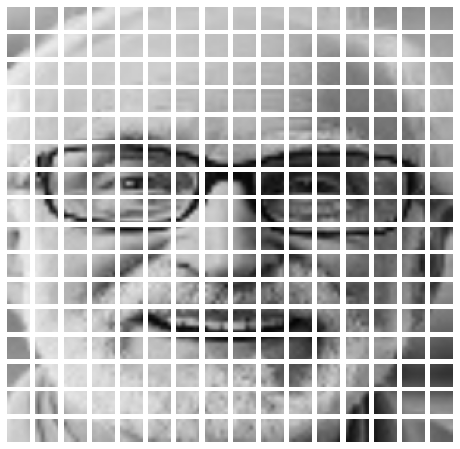

In [ ]:
plt.figure(figsize = (8,8))

for i in range(patches.shape[1]):

    ax = plt.subplot(16,16, i+1)
    plt.imshow(tf.reshape(patches[0,i,:], (16,16,3)))
    plt.axis("off")

In [ ]:
class PatchEncoder(Layer):
  def __init__(self, N_PATCHES, HIDDEN_SIZE):
    super(PatchEncoder, self).__init__(name = 'patch_encoder')

    self.linear_projection = Dense(HIDDEN_SIZE)
    self.positional_embedding = Embedding(N_PATCHES, HIDDEN_SIZE )
    self.N_PATCHES = N_PATCHES

  def call(self, x):
    patches = tf.image.extract_patches(
        images=x,
        sizes=[1, CONFIGURATION["PATCH_SIZE"], CONFIGURATION["PATCH_SIZE"], 1],
        strides=[1, CONFIGURATION["PATCH_SIZE"], CONFIGURATION["PATCH_SIZE"], 1],
        rates=[1, 1, 1, 1],
        padding='VALID')

    patches = tf.reshape(patches, (tf.shape(patches)[0], 256, patches.shape[-1]))

    embedding_input = tf.range(start = 0, limit = self.N_PATCHES, delta = 1 )
    output = self.linear_projection(patches) + self.positional_embedding(embedding_input)

    return output

### TransformerEncoder

In [ ]:
class TransformerEncoder(Layer):
  def __init__(self, N_HEADS, HIDDEN_SIZE):
    super(TransformerEncoder, self).__init__(name = 'transformer_encoder')

    self.layer_norm_1 = LayerNormalization()
    self.layer_norm_2 = LayerNormalization()

    self.multi_head_att = MultiHeadAttention(N_HEADS, HIDDEN_SIZE )

    self.dense_1 = Dense(HIDDEN_SIZE, activation = tf.nn.gelu)
    self.dense_2 = Dense(HIDDEN_SIZE, activation = tf.nn.gelu)

  def call(self, input):
    x_1 = self.layer_norm_1(input)
    x_1 = self.multi_head_att(x_1, x_1)

    x_1 = Add()([x_1, input])

    x_2 = self.layer_norm_2(x_1)
    x_2 = self.dense_1(x_2)
    output = self.dense_2(x_2)
    output = Add()([output, x_1])

    return output

### ViT Model

In [ ]:
class ViT(Model):
  def __init__(self, N_HEADS, HIDDEN_SIZE, N_PATCHES, N_LAYERS, N_DENSE_UNITS):
    super(ViT, self).__init__(name = 'vision_transformer')
    self.N_LAYERS = N_LAYERS
    self.patch_encoder = PatchEncoder(N_PATCHES, HIDDEN_SIZE)
    self.trans_encoders = [TransformerEncoder(N_HEADS, HIDDEN_SIZE) for _ in range(N_LAYERS)]
    self.dense_1 = Dense(N_DENSE_UNITS, tf.nn.gelu)
    self.dense_2 = Dense(N_DENSE_UNITS, tf.nn.gelu)
    self.dense_3 = Dense(CONFIGURATION["NUM_CLASSES"], activation = 'softmax')
  def call(self, input, training = True):

    x = self.patch_encoder(input)

    for i in range(self.N_LAYERS):
      x = self.trans_encoders[i](x)
    x = Flatten()(x)
    x = self.dense_1(x)
    x = self.dense_2(x)

    return self.dense_3(x)

In [ ]:
vit = ViT(
    N_HEADS = 4, HIDDEN_SIZE = 768, N_PATCHES = 256,
    N_LAYERS = 2, N_DENSE_UNITS = 128)
vit(tf.zeros([2,256,256,3]))

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.17217974, 0.352223  , 0.4755972 ],
       [0.17217974, 0.352223  , 0.4755972 ]], dtype=float32)>

In [ ]:
vit.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 patch_encoder (PatchEncoder  multiple                 787200    
 )                                                               
                                                                 
 transformer_encoder (Transf  multiple                 10631424  
 ormerEncoder)                                                   
                                                                 
 transformer_encoder (Transf  multiple                 10631424  
 ormerEncoder)                                                   
                                                                 
 dense_13 (Dense)            multiple                  25165952  
                                                                 
 dense_14 (Dense)            multiple                  16512     
                                                

## HuggingFace ViT

### Installation

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 5.1 MB/s 
     |████████████████████████████████| 596 kB 61.5 MB/s 
     |████████████████████████████████| 6.6 MB 59.1 MB/s 
     |████████████████████████████████| 86 kB 6.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


### Training

In [ ]:
resize_rescale_hf = tf.keras.Sequential([
       Resizing(224, 224),
       Rescaling(1./255),
       Permute((3,1,2))
])

In [ ]:
from transformers import ViTFeatureExtractor, TFViTModel


base_model = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

inputs = Input(shape = (256,256,3))
x = resize_rescale_hf(inputs)
x = base_model.vit(x)[0][:,0,:]
#print(x)
output = Dense(CONFIGURATION["NUM_CLASSES"], activation = 'softmax')(x)

hf_model = tf.keras.Model(inputs=inputs, outputs=output)

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFViTModel.

All the layers of TFViTModel were initialized from the model checkpoint at google/vit-base-patch16-224-in21k.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


In [ ]:
test_image = cv2.imread("/content/human-emotions-datasethes/Emotions Dataset/Emotions Dataset/train/happy/387249.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"] ,CONFIGURATION["IM_SIZE"]))

In [ ]:
hf_model(tf.expand_dims(test_image, axis = 0))

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.32100818, 0.3514786 , 0.32751322]], dtype=float32)>

In [ ]:
hf_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 3, 224, 224)       0         
                                                                 
 vit (TFViTMainLayer)        TFBaseModelOutputWithPoo  86389248  
                             ling(last_hidden_state=(            
                             None, 197, 768),                    
                              pooler_output=(None, 76            
                             8),                                 
                              hidden_states=None, att            
                             entions=None)                       
                                                                 
 tf.__operators__.getitem (S  (None, 768)              0     

### Get Attention Maps

In [ ]:
from transformers import ViTFeatureExtractor, TFViTModel, ViTConfig

configuration = ViTConfig()
configuration.output_attentions = True

base_model = TFViTModel.from_pretrained(
    pretrained_model_name_or_path = "google/vit-base-patch16-224-in21k",
    config = configuration,
    )
inputs = Input(shape = (256,256,3))
x = resize_rescale_hf(inputs)
x = base_model.vit(x)['attentions']

model = tf.keras.Model(inputs=inputs, outputs=x)

All model checkpoint layers were used when initializing TFViTModel.

All the layers of TFViTModel were initialized from the model checkpoint at google/vit-base-patch16-224-in21k.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


# Training

## Class Weighting

In [ ]:
n_sample_0 = 1525 # angry
n_sample_1 = 3019 # happy
n_sample_2 = 2255 # sad


In [ ]:
class_weights = {0:6799/n_sample_0, 1: 6799/n_sample_1, 2: 6799/n_sample_2}

In [ ]:
print(class_weights)

{0: 4.458360655737705, 1: 2.2520702219277906, 2: 3.015077605321508}


## Callbacks

In [ ]:
checkpoint_callback = ModelCheckpoint(
    'best_weights',
    monitor='val_accuracy',
    mode = 'max',
    verbose=1,
    save_best_only=True,

    )

In [ ]:
class LogConfMatrix(Callback):
  def on_epoch_end(self, epoch, logs):
    predicted = []
    labels = []

    for im, label in validation_dataset:
      predicted.append(hf_model(im))
      labels.append(label.numpy())

    pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])
    lab = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])

    cm = wandb.plot.confusion_matrix(
        y_true=lab,
        preds=pred,
        class_names=CONFIGURATION["CLASS_NAMES"])

    wandb.log({"conf_mat": cm})

In [ ]:
class LogResultsTable(Callback):
  def on_epoch_end(self, epoch, logs):

    columns=["image", "Predicted", "Label"]

    val_table = wandb.Table(columns = columns)


    for im, label in validation_dataset.take(25):

      pred = CONFIGURATION["CLASS_NAMES"][tf.argmax(hf_model(im), axis = -1).numpy()[0]]
      label = CONFIGURATION["CLASS_NAMES"][tf.argmax(label, axis = -1).numpy()[0]]

      row = [wandb.Image(im), pred, label]

      val_table.add_data(*row)


    wandb.log({"Model Results" : val_table})


## Train

In [ ]:
loss_function = CategoricalCrossentropy()
#loss_function = SparseCategoricalCrossentropy()

In [ ]:

metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k=2, name = "top_k_accuracy")]

In [ ]:
backbone.trainable=False

In [ ]:
pretrained_model.compile(
  optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]),
  loss = loss_function,
  metrics = metrics,
)

In [ ]:
history = pretrained_model.fit(
  training_dataset,
  #validation_data = validation_dataset,
  epochs = CONFIGURATION["N_EPOCHS"],
  verbose = 1,
  #class_weight = class_weights,
  #callbacks = [WandbCallback(), LogConfMatrix(), LogResultsTable()]
)

Epoch 1/20
130/213 [=================>............] - ETA: 27s - loss: 0.1770 - accuracy: 0.9260 - top_k_accuracy: 0.9858

KeyboardInterrupt: ignored

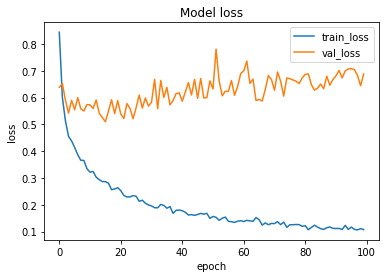

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

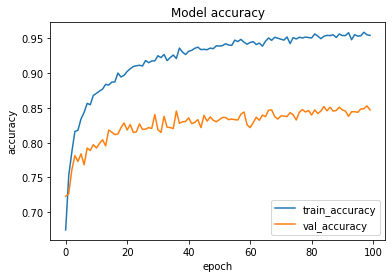

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [ ]:
pretrained_model.save("/content/drive/MyDrive/Bang/eff_keras.h5")

## Ensembling

In [ ]:
inputs = Input(shape = (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3))

y_1 = resnet_34(inputs)
y_2 = pretrained_model(inputs)

output = 0.5*y_1 + 0.5*y_1

ensemble_model = Model(inputs = inputs, outputs = output)

# Evaluation

In [ ]:
model.load_weights('best_weights')

In [ ]:
hf_model.evaluate(validation_dataset)

2278/2278 [==============================] - 62s 27ms/step - loss: 0.3582 - accuracy: 0.8946 - top_k_accuracy: 0.9715


[0.358234167098999, 0.8946444392204285, 0.9714661836624146]

# Testing

In [ ]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/sad/123731.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"] ,CONFIGURATION["IM_SIZE"]))
im = tf.constant(test_image, dtype = tf.float32)

im = tf.expand_dims(im, axis = 0)
print(pretrained_model(im))
print(CONFIGURATION['CLASS_NAMES'][tf.argmax(pretrained_model(im), axis = -1).numpy()[0]])

tf.Tensor([[3.1441802e-01 1.5602846e-04 6.8542594e-01]], shape=(1, 3), dtype=float32)
sad


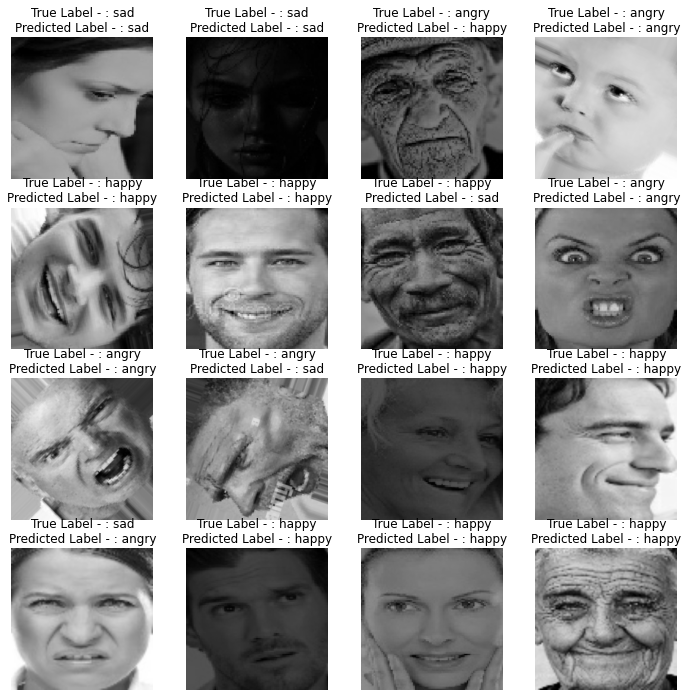

In [ ]:
plt.figure(figsize = (12,12))

for images, labels in validation_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)

    plt.title("True Label - : " + CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis = -1).numpy()]
              + "\n" + "Predicted Label - : "
              + CONFIGURATION["CLASS_NAMES"][int(tf.argmax(pretrained_model(tf.expand_dims(images[i], axis = 0)), axis =-1).numpy()[0])] )
    plt.axis("off")

## Confusion Matrix

In [ ]:
predicted = []
labels = []

for im, label in validation_dataset:
  predicted.append(pretrained_model(im))
  labels.append(label.numpy())

In [ ]:
print(np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()]))
print(np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()]))

[1 1 2 ... 2 1 0]
[1 1 2 ... 2 1 0]


In [ ]:
pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])
lab = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])

[[397  48  70]
 [ 27 909  70]
 [ 61  87 609]]


Text(0.5, 51.0, 'Predicted')

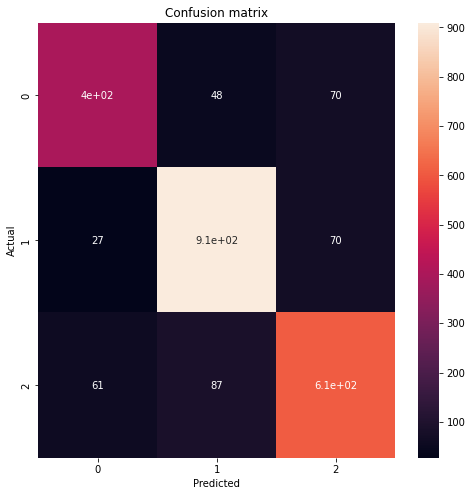

In [ ]:
cm = confusion_matrix(lab, pred)
print(cm)
plt.figure(figsize=(8,8))

sns.heatmap(cm, annot=True,)
plt.title('Confusion matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Visualization

## Feature Map Visualization

In [ ]:
vgg_backbone = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights= None,
    input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),

)

In [ ]:
vgg_backbone.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
def is_conv(layer_name):
  if 'conv' in layer_name:
    return True
  else:
    return False

In [ ]:
feature_maps = [layer.output for layer in vgg_backbone.layers[1:] if is_conv(layer.name)]
feature_map_model = Model(
    inputs = vgg_backbone.input,
    outputs = feature_maps
)

feature_map_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
test_image = cv2.imread("/content/human-emotions-datasethes/Emotions Dataset/Emotions Dataset/test/happy/111073.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]))

im = tf.constant(test_image, dtype = tf.float32)
im = tf.expand_dims(im, axis = 0)

f_maps = feature_map_model.predict(im)

In [ ]:
print(len(f_maps))

13


In [ ]:
for i in range(len(f_maps)):
  print(f_maps[i].shape)

(1, 256, 256, 64)
(1, 256, 256, 64)
(1, 128, 128, 128)
(1, 128, 128, 128)
(1, 64, 64, 256)
(1, 64, 64, 256)
(1, 64, 64, 256)
(1, 32, 32, 512)
(1, 32, 32, 512)
(1, 32, 32, 512)
(1, 16, 16, 512)
(1, 16, 16, 512)
(1, 16, 16, 512)


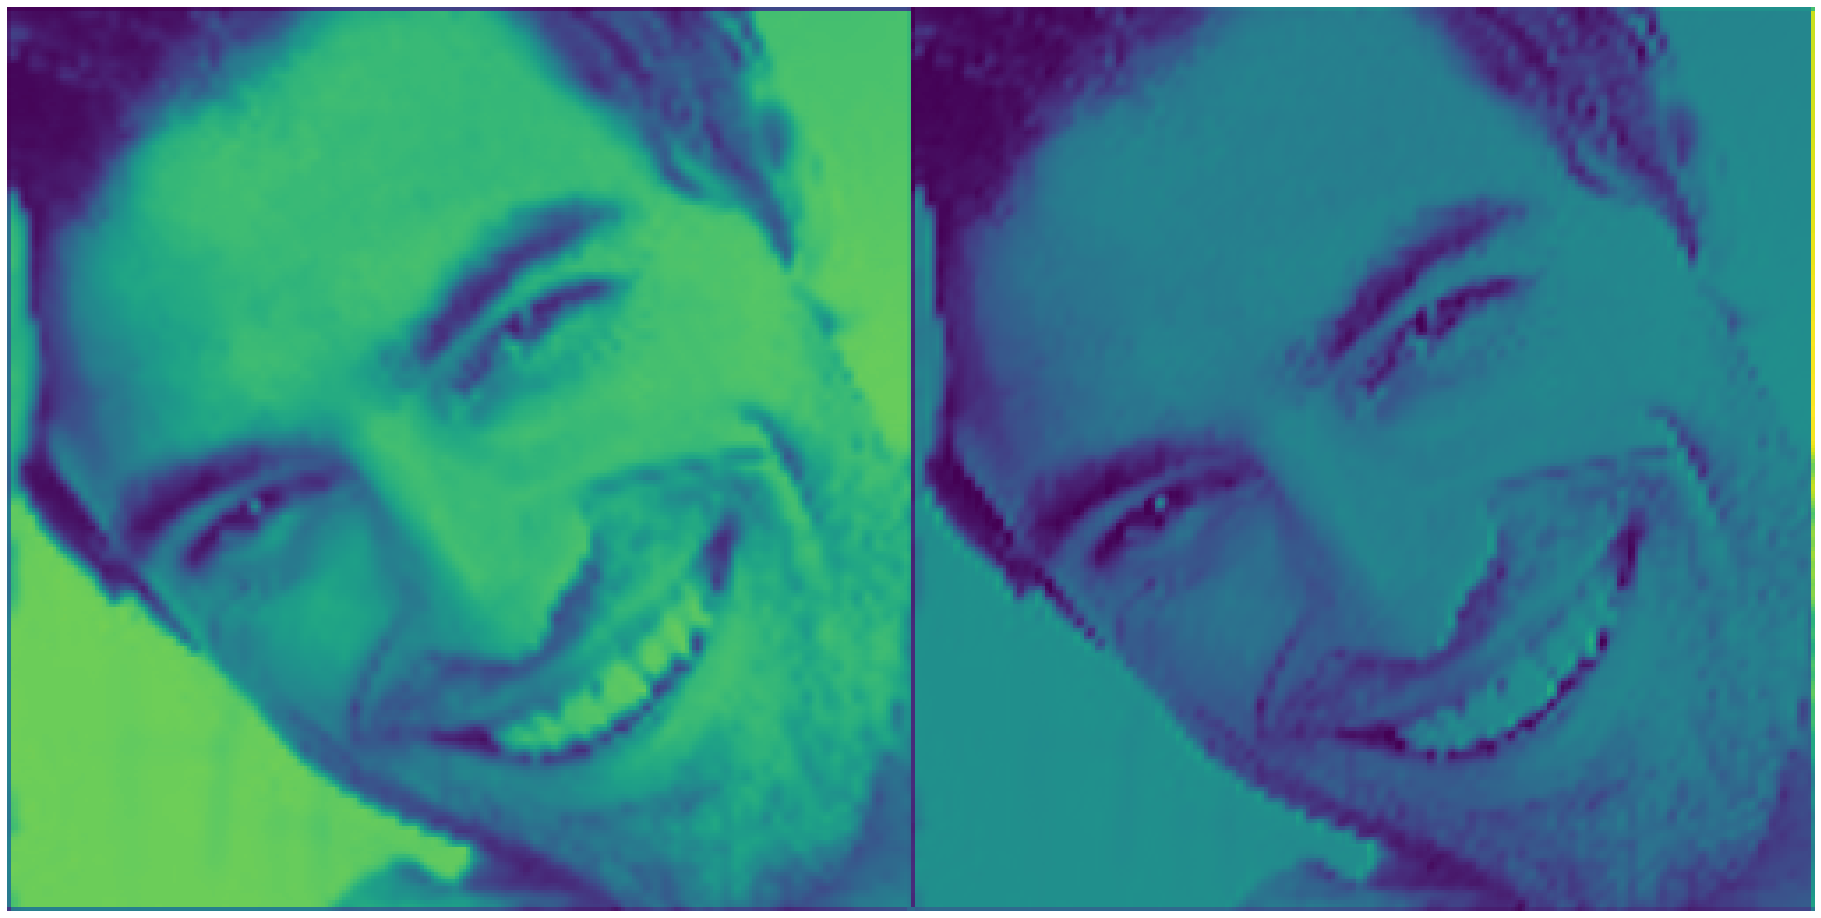

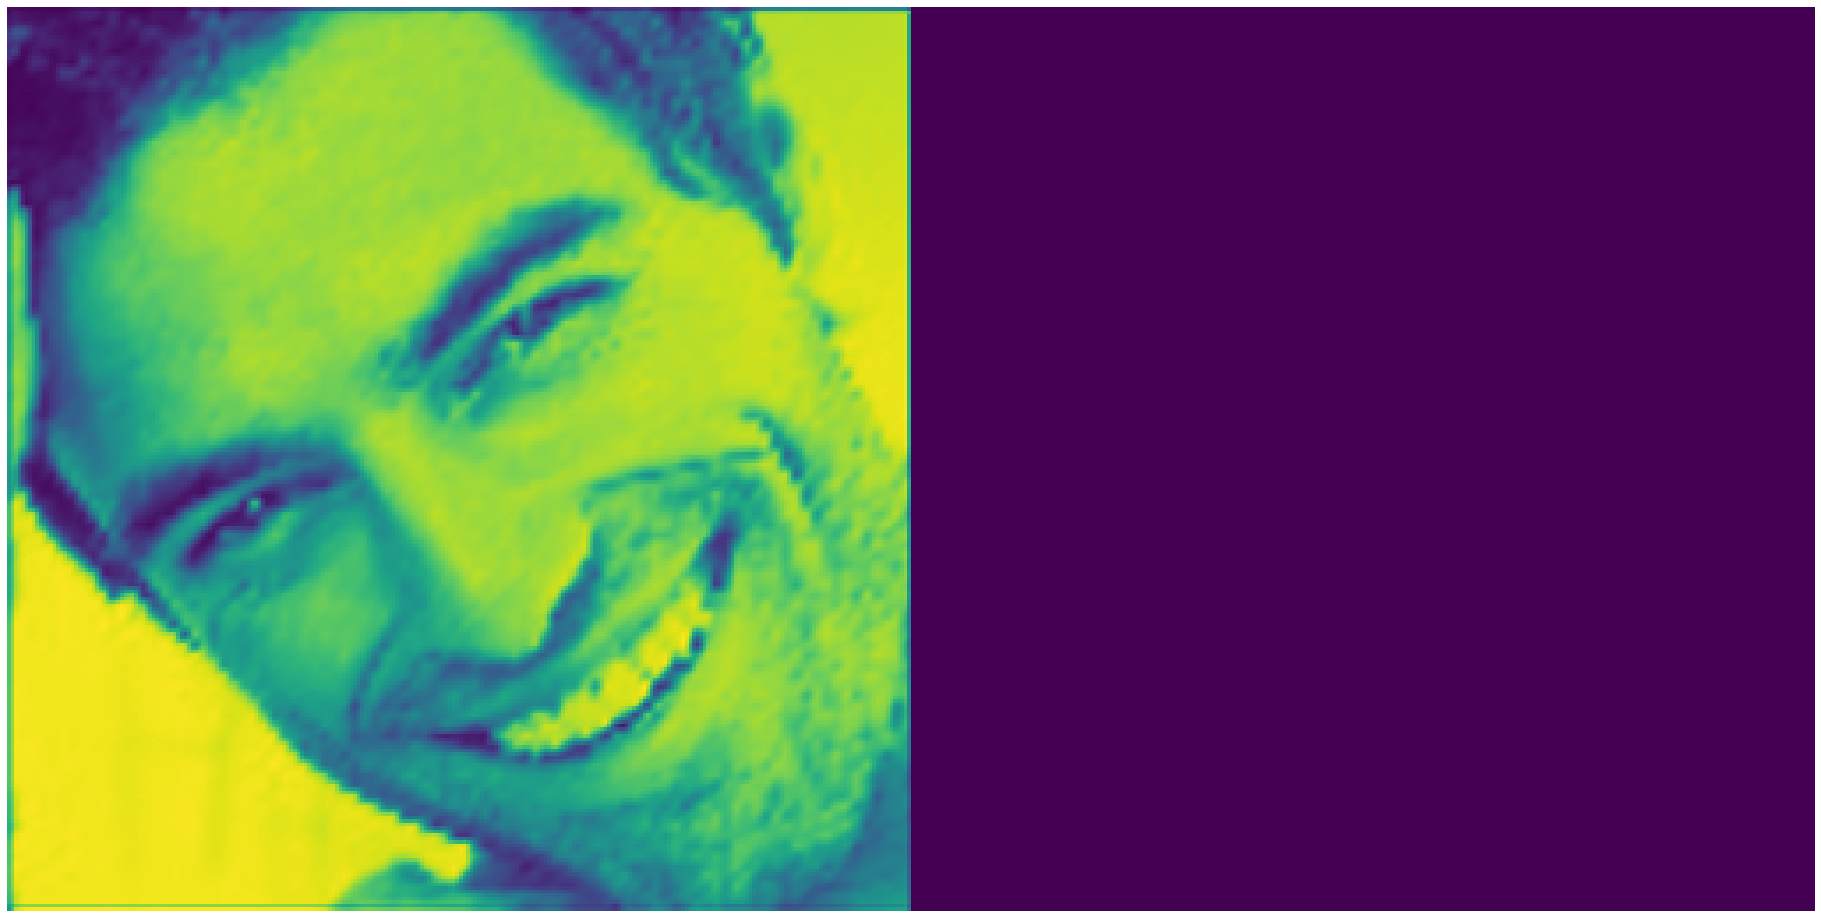

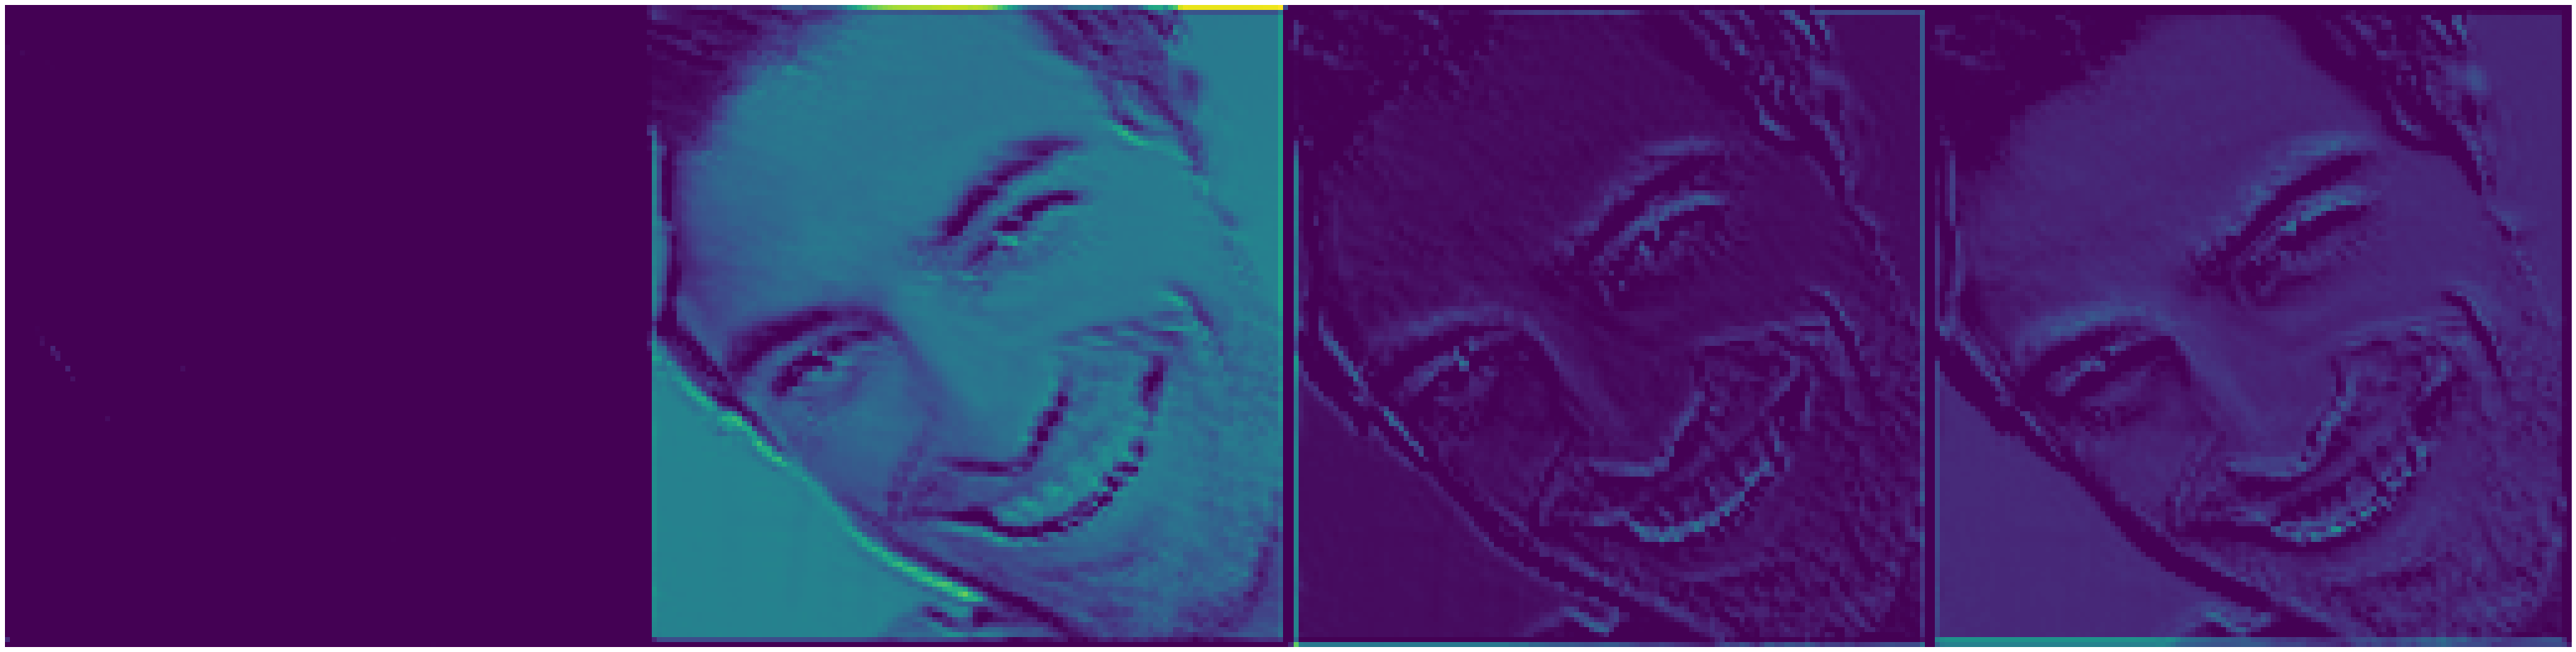

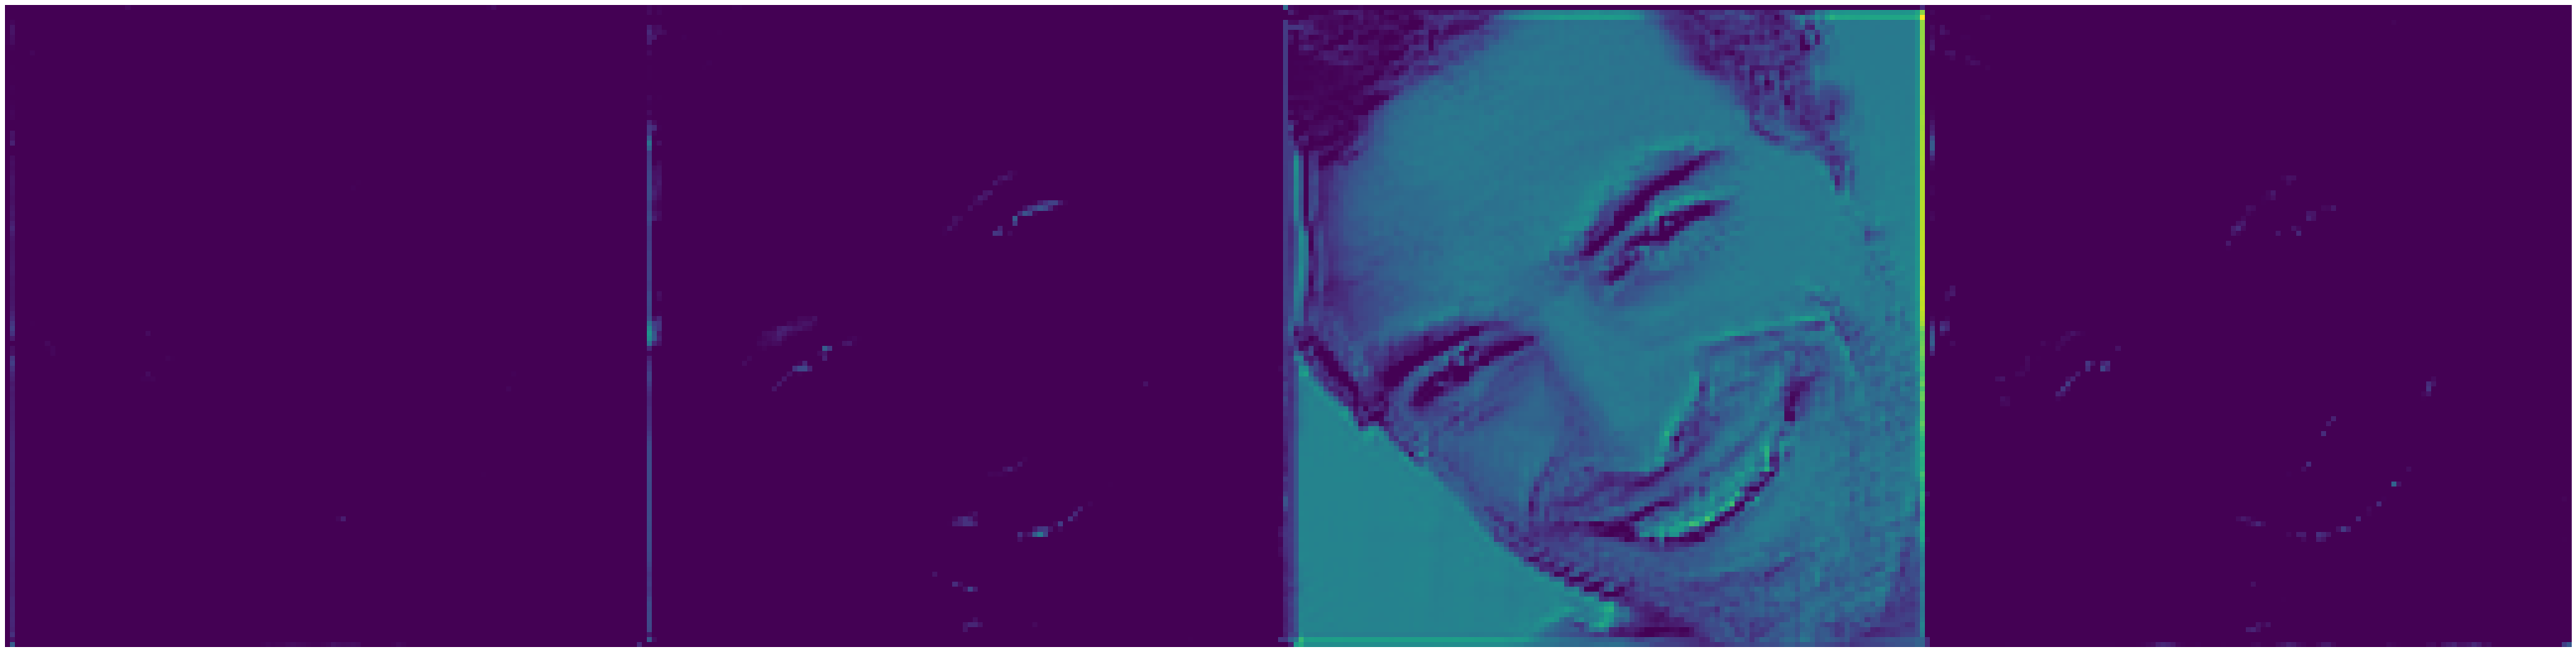

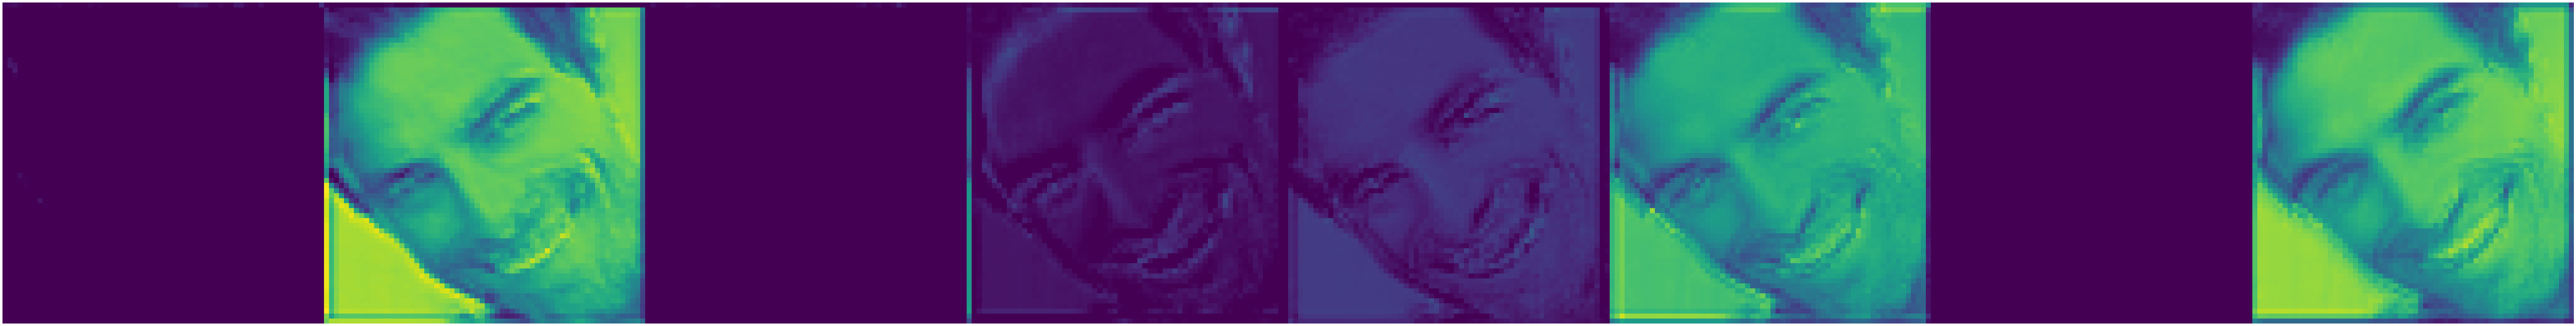

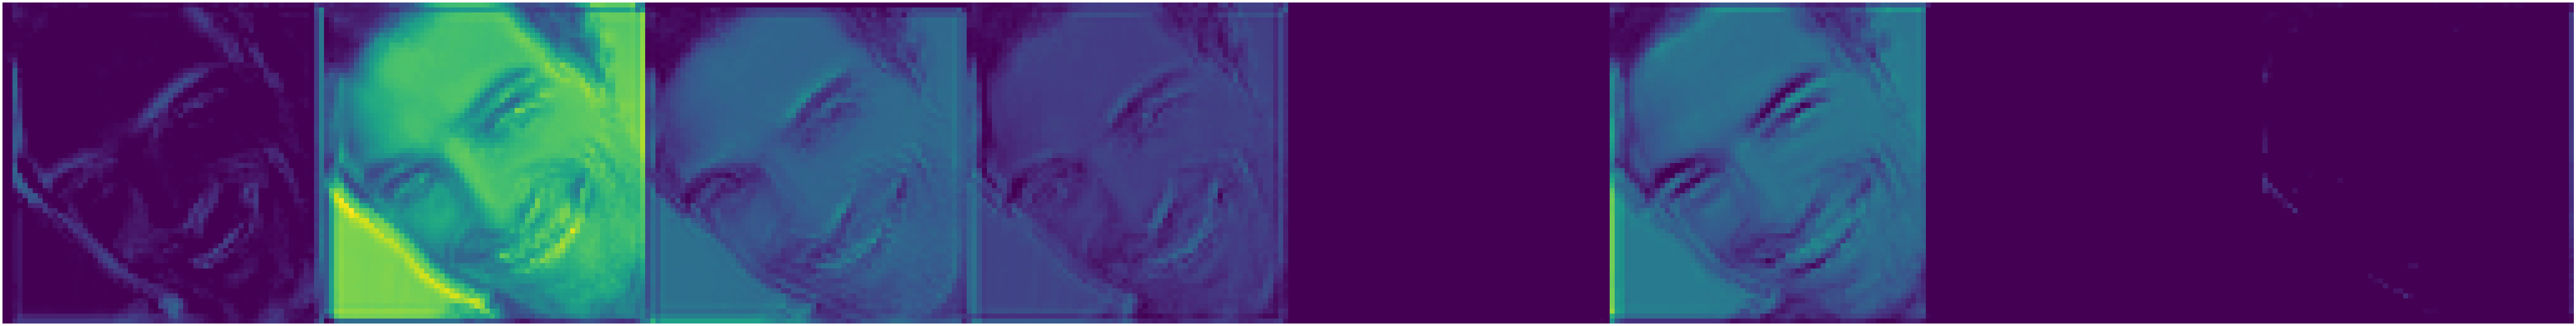

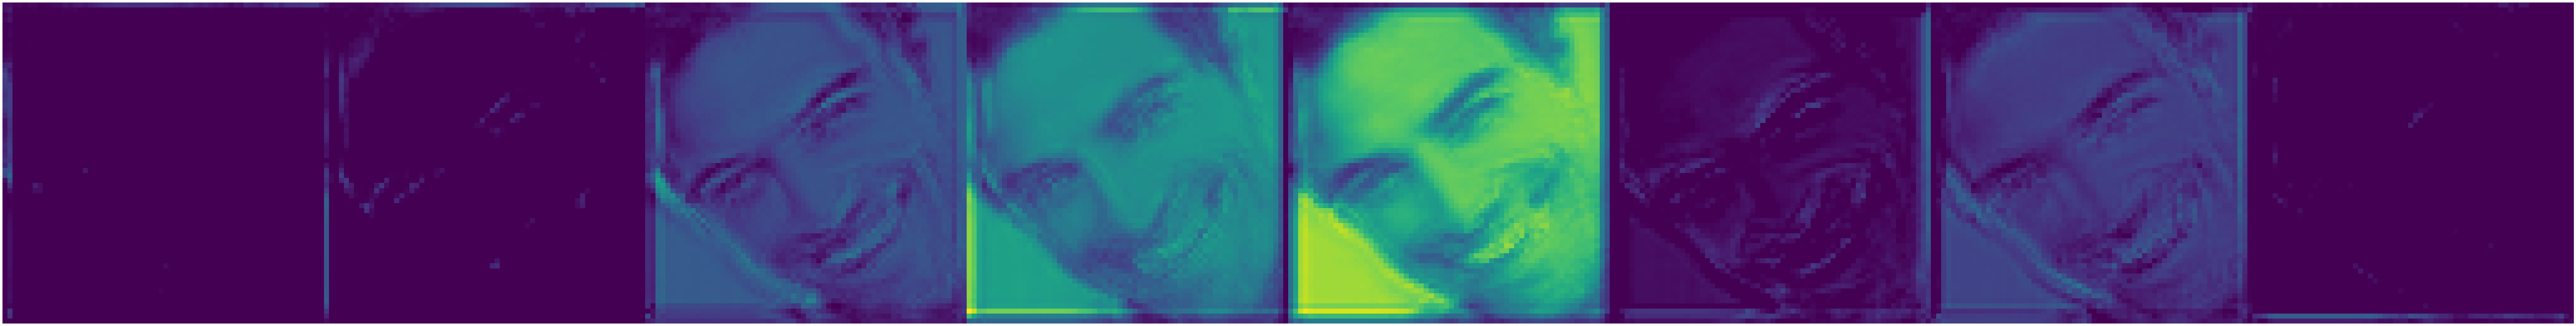

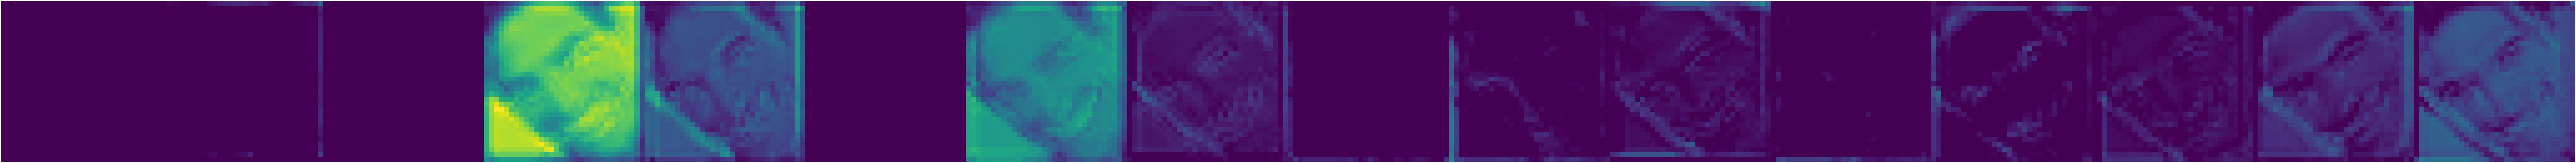

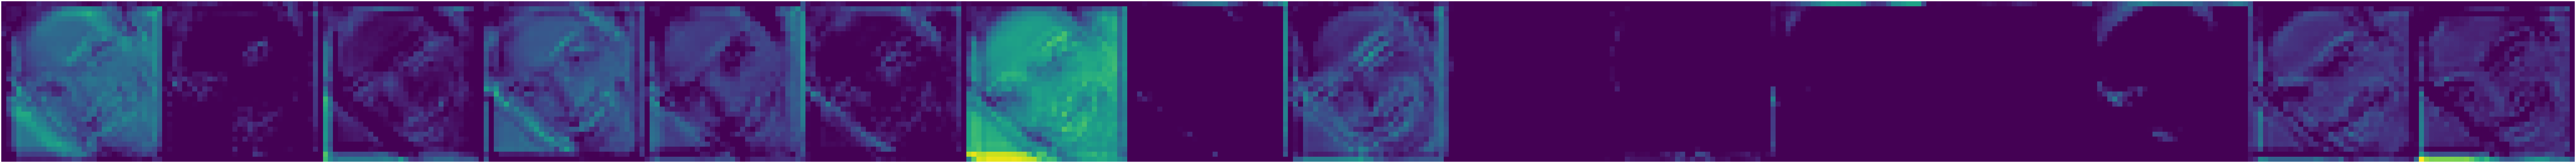

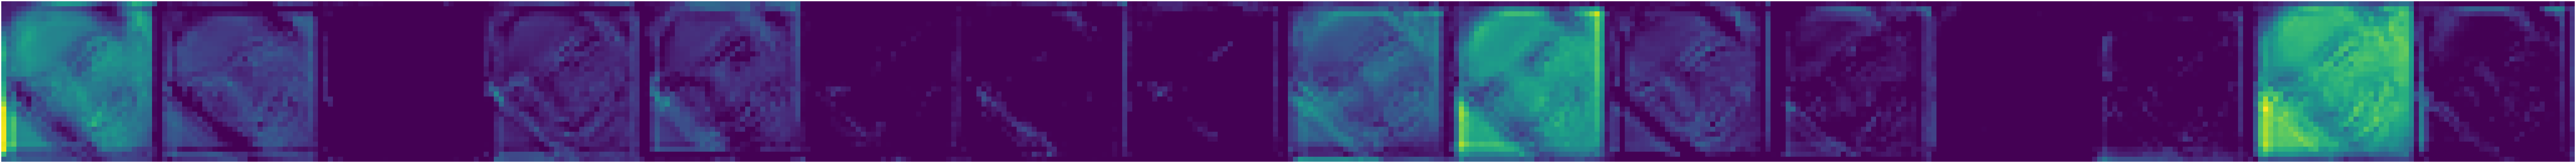

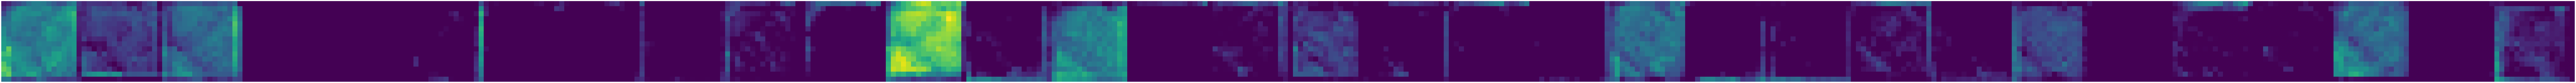

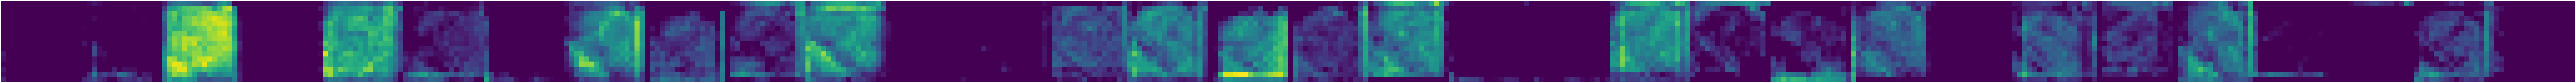

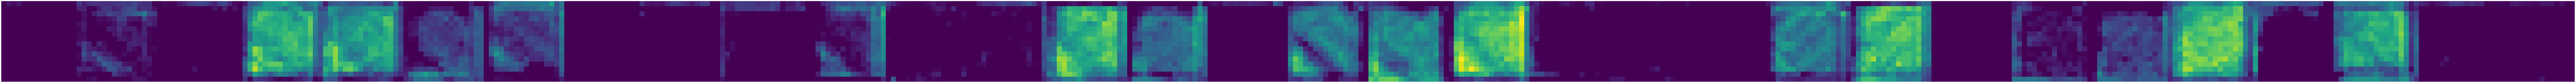

In [ ]:
for i in range(len(f_maps)):
  plt.figure(figsize = (256,256))
  f_size = f_maps[i].shape[1]
  n_channels = f_maps[i].shape[3]
  joint_maps = np.ones((f_size, f_size*n_channels ))

  axs = plt.subplot(len(f_maps), 1, i+1)

  for j in range(n_channels):
    joint_maps[:, f_size*j:f_size*(j+1)] = f_maps[i][..., j]

  plt.imshow(joint_maps[:,0:512])
  plt.axis("off")


## GradCam

In [ ]:
backbone = tf.keras.applications.efficientnet.EfficientNetB5(
    include_top = False,
    weights='imagenet',
    input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
    )
backbone.trainable=False

115263384/115263384 [==============================] - 1s 0us/step


In [ ]:
x = backbone.output

x = GlobalAveragePooling2D()(x)
x = Dense( CONFIGURATION["N_DENSE_1"], activation = "relu")(x)
x = Dense( CONFIGURATION["N_DENSE_2"], activation = "relu")(x)
output = Dense( CONFIGURATION["NUM_CLASSES"], activation = "softmax")(x)

pretrained_model = Model(backbone.inputs, output)
pretrained_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 256, 256, 3)  7           ['rescaling_1[0][0]']            
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 256, 256, 3)  0           ['normalization[0][0]']      

In [ ]:
pretrained_model.load_weights('/content/drive/MyDrive/Bang/mobilenet_human_emotions.h5')

In [ ]:
img_path = "/content/human-emotions-datasethes/Emotions Dataset/Emotions Dataset/train/happy/202291.jpg"

In [ ]:
test_image = cv2.imread(img_path)
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"] ,CONFIGURATION["IM_SIZE"]))
im = tf.constant(test_image, dtype = tf.float32)
img_array = tf.expand_dims(im, axis = 0)
print(img_array.shape)

(1, 256, 256, 3)


In [ ]:
preds = pretrained_model.predict(img_array)

1/1 [==============================] - 0s 35ms/step


In [ ]:
print(preds)

[[1.1035408e-02 9.8881429e-01 1.5026570e-04]]


In [ ]:
np.argmax(preds[0])

1

In [ ]:
last_conv_layer_name = "top_activation"
last_conv_layer = pretrained_model.get_layer(last_conv_layer_name)
last_conv_layer_model = Model(pretrained_model.inputs, last_conv_layer.output)

In [ ]:
classifier_layer_names = [
 "global_average_pooling2d",
 "dense",
 "dense_1",
 "dense_2"
]

In [ ]:
classifier_input = Input(shape=(8,8,2048))
x = classifier_input
for layer_name in classifier_layer_names:
 x = pretrained_model.get_layer(layer_name)(x)
classifier_model = Model(classifier_input, x)

In [ ]:
with tf.GradientTape() as tape:
  last_conv_layer_output = last_conv_layer_model(img_array)
  preds = classifier_model(last_conv_layer_output)
  top_pred_index = tf.argmax(preds[0])
  print(top_pred_index)
  top_class_channel = preds[:, top_pred_index]

grads = tape.gradient(top_class_channel, last_conv_layer_output)

tf.Tensor(1, shape=(), dtype=int64)


In [ ]:
grads.shape

TensorShape([1, 8, 8, 2048])

In [ ]:
pooled_grads = tf.reduce_mean(grads, axis=(0,1,2)).numpy()

In [ ]:
print(pooled_grads.shape)

(2048,)


In [ ]:
last_conv_layer_output = last_conv_layer_output.numpy()[0]
for i in range(2048):
  last_conv_layer_output[:, :, i] *= pooled_grads[i]

In [ ]:
print(last_conv_layer_output.shape)

(8, 8, 2048)


In [ ]:
heatmap = np.sum(last_conv_layer_output, axis=-1)

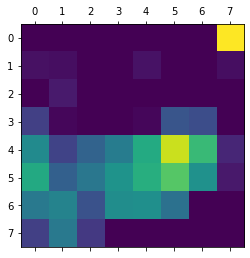

In [ ]:
heatmap=tf.nn.relu(heatmap)
plt.matshow(heatmap)

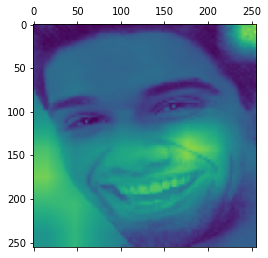

In [ ]:
resized_heatmap=cv2.resize(np.array(heatmap),(256,256))
plt.matshow(resized_heatmap*255+img_array[0,:,:,0]/255)

# Exporting to Onnx format

In [ ]:
hf_model.save('vit_finetuned')

INFO:tensorflow:Assets written to: vit_finetuned/assets


INFO:tensorflow:Assets written to: vit_finetuned/assets


In [ ]:
hf_model.save('vit_finetuned.h5')

## Installation

In [ ]:
!pip install -U tf2onnx
!pip install onnxruntime-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 442 kB 12.6 MB/s 
     |████████████████████████████████| 13.1 MB 43.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 115.3 MB 2.8 MB/s 
     |████████████████████████████████| 46 kB 3.4 MB/s 
     |████████████████████████████████| 86 kB 5.6 MB/s 


In [ ]:
import onnxruntime as rt
rt.get_device()

'GPU'

## Conversion

### From TensorFlow SavedModel

In [ ]:
!python -m tf2onnx.convert --saved-model vit_finetuned/ --output vit_onnx.onnx

/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2022-05-25 13:11:26,360 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2022-05-25 13:11:34,252 - INFO - Signatures found in model: [serving_default].
2022-05-25 13:11:34,252 - WARNING - '--signature_def' not specified, using first signature: serving_default
2022-05-25 13:11:34,253 - INFO - Output names: ['dense']
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
2022-05-25 13:11:45,495 - WARNING - From /usr/local/lib/python3.7/dist-packages/tf2onnx/tf_loader.py:711: extract_sub_graph (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
2022-05-25 13:11:50,911 - INFO - Using tenso

### From Keras Model

In [ ]:
import tf2onnx
import onnxruntime as rt

spec = (tf.TensorSpec(
    (None, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
    tf.float32, name="input"),)

output_path = "lenet_keras.onnx"

model_proto, _ = tf2onnx.convert.from_keras(model_for_export, input_signature=spec, opset=13, output_path=output_path)
output_names = [n.name for n in model_proto.graph.output]

In [ ]:
print(output_names)

['dense_2']


In [ ]:
output_names = ['dense']

## Inference

In [ ]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/sad/123731.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"] ,CONFIGURATION["IM_SIZE"]))
im = test_image.astype(np.float32)

im = np.expand_dims(im, axis = 0)

In [ ]:
N_PREDICTIONS = 10

### Benchmarking Onnx

In [ ]:
providers=['CPUExecutionProvider' ]
m = rt.InferenceSession("/content/drive/MyDrive/Bang/vit_keras.onnx", providers=providers)
t1 = time.time()

for _ in range(N_PREDICTIONS):
  onnx_pred = m.run(['dense'], {"input": im})
print("Time for a single Prediction", (time.time() - t1)/N_PREDICTIONS)

Time for a single Prediction 0.2902926683425903


In [ ]:
print(onnx_pred)

[array([[0.00484342, 0.00301275, 0.99214387]], dtype=float32)]


### Benchmarking TF

In [ ]:
t1 = time.time()
for _ in range(N_PREDICTIONS):
  hf_model(im)
print("Time for a single Prediction", (time.time() - t1)/N_PREDICTIONS)

Time for a single Prediction 0.7937646389007569


In [ ]:
tf, gpu = 0.15s
tf, cpu = 0.8s
tf_size = 1000MB

onnx, cpu = 0.5s
onnx, gpu = 0.025s
onnx_size = 328MB

onnx_quantized, cpu = 0.4s
onnx_quantized, gpu = 0.3s
onnx_quantized_size = 83MB

In [ ]:
0.8/0.35

2.285714285714286

## Quantization with Onnx

In [ ]:
import onnx
from onnxruntime.quantization import quantize_dynamic, QuantType

In [ ]:
model_fp32 = '/content/eff_keras.onnx'
model_quant = '/content/eff_quantized.onnx'

quantized_model = quantize_dynamic(model_fp32, model_quant, weight_type = QuantType.QUInt8)

Ignore MatMul due to non constant B: /[model/vit/encoder/layer_._0/attention/attention/MatMul]
Ignore MatMul due to non constant B: /[model/vit/encoder/layer_._0/attention/attention/MatMul_1]
Ignore MatMul due to non constant B: /[model/vit/encoder/layer_._1/attention/attention/MatMul]
Ignore MatMul due to non constant B: /[model/vit/encoder/layer_._1/attention/attention/MatMul_1]
Ignore MatMul due to non constant B: /[model/vit/encoder/layer_._2/attention/attention/MatMul]
Ignore MatMul due to non constant B: /[model/vit/encoder/layer_._2/attention/attention/MatMul_1]
Ignore MatMul due to non constant B: /[model/vit/encoder/layer_._3/attention/attention/MatMul]
Ignore MatMul due to non constant B: /[model/vit/encoder/layer_._3/attention/attention/MatMul_1]
Ignore MatMul due to non constant B: /[model/vit/encoder/layer_._4/attention/attention/MatMul]
Ignore MatMul due to non constant B: /[model/vit/encoder/layer_._4/attention/attention/MatMul_1]
Ignore MatMul due to non constant B: /[m

### Accuracy Drop due to Quantization

In [ ]:
def accuracy(model):
  total, acc = 0,0
  for im, label in validation_dataset:
    onnx_pred = model.run(output_names, {"input": np.array(im)})

    if(int(np.argmax(onnx_pred, axis = -1)[0][0]) == int(np.argmax(label, axis = -1)[0])):
      acc += 1

    total += 1
  return acc/total

In [ ]:
providers=['CUDAExecutionProvider']
m = rt.InferenceSession("/content/drive/MyDrive/Bang/vit_keras.onnx", providers=providers)
m_q = rt.InferenceSession("/content/vit_quantized.onnx", providers=providers)
print(accuracy(m_q))
print(accuracy(m))

0.9051799824407375
0.9051799824407375


In [ ]:
!pip install onnxruntime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.5 MB 27.0 MB/s 
     |████████████████████████████████| 46 kB 4.0 MB/s 
     |████████████████████████████████| 86 kB 8.0 MB/s 


In [ ]:
import onnxruntime as rt

In [ ]:
providers=['CPUExecutionProvider' ]
m_q = rt.InferenceSession("/content/drive/MyDrive/Bang/eff_quantized.onnx", providers=providers)

In [ ]:
img_path = "/content/dataset/Emotions Dataset/Emotions Dataset/test/happy/553112.jpg"
test_image = cv2.imread(img_path)
print(test_image.shape)
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"] ,CONFIGURATION["IM_SIZE"]))
im = np.float32(test_image)
img_array = np.expand_dims(im, axis = 0)
print(img_array.shape)

(90, 90, 3)
(1, 256, 256, 3)


In [ ]:
onnx_pred = m_q.run(['dense'], {"input":img_array})
print(np.argmax(onnx_pred[0][0]))

fastapi==0.87.0
numpy==1.23.4
onnxruntime==1.13.1
Pillow==9.3.0

1


In [ ]:
!pip install onnxruntime==1.13.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.5 MB 5.7 MB/s 
     |████████████████████████████████| 46 kB 4.1 MB/s 
     |████████████████████████████████| 86 kB 5.5 MB/s 


# Quantization in TensorFlow

### Installation and Import

In [ ]:
!pip install -q tensorflow-model-optimization

     |████████████████████████████████| 237 kB 4.1 MB/s 


In [ ]:
import tensorflow_model_optimization as tfmot

## Quantization Aware Training

In [ ]:
backbone,

x = GlobalAveragePooling2D()(backbone.output)
x = Dense( CONFIGURATION["N_DENSE_1"], activation = "relu")(x)
x = BatchNormalization()(x)
x = Dense( CONFIGURATION["N_DENSE_2"], activation = "relu")(x)
output = Dense( CONFIGURATION["NUM_CLASSES"], activation = "softmax")(x)

pretrained_func_model = tf.keras.Model(inputs = backbone.input, outputs = output )

pretrained_func_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 256, 256, 3)  7           ['rescaling_1[0][0]']            
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 257, 257, 3)  0           ['normalization[0][0]']      

In [ ]:
pretrained_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional)  (None, 8, 8, 1792)       17673823  
                                                                 
 global_average_pooling2d_2   (None, 1792)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_7 (Dense)             (None, 1024)              1836032   
                                                                 
 batch_normalization_2 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dense_8 (Dense)             (None, 128)               131200    
                                                                 
 dense_9 (Dense)             (None, 3)                

In [ ]:
#quant_aware = tfmot.quantization.keras.quantize_model(lenet_model)

In [ ]:
def apply_quantization_to_conv(layer):
  if "conv" in layer.name:
    return tfmot.quantization.keras.quantize_annotate_layer(layer)
  return layer

In [ ]:
quant_aware_eff = tf.keras.models.clone_model(
    pretrained_func_model, clone_function=apply_quantization_to_conv
)

In [ ]:
quant_aware_eff.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 256, 256, 3)  7           ['rescaling_1[1][0]']            
                                                                                                  
 quantize_annotate (QuantizeAnn  (None, 257, 257, 3)  0          ['normalization[1][0]']      

In [ ]:
quant_aware_model = tfmot.quantization.keras.quantize_apply(quant_aware_eff)
quant_aware_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 256, 256, 3)  7           ['rescaling_1[1][0]']            
                                                                                                  
 quant_stem_conv_pad (QuantizeW  (None, 257, 257, 3)  1          ['normalization[1][0]']      

## Post Training Quantization

In [ ]:
pretrained_model.load_weights("/content/drive/MyDrive/Bang/eff_keras.h5")

In [ ]:
pretrained_model.evaluate(validation_dataset)

72/72 [==============================] - 202s 3s/step - loss: 0.6804 - accuracy: 0.8406 - top_k_accuracy: 0.9565


[0.6804420351982117, 0.8406496644020081, 0.9565408229827881]

In [ ]:
def representative_data_gen():
  for input_value,j in training_dataset.take(20):
    yield [input_value]

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(pretrained_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
converter.representative_dataset = representative_data_gen

In [ ]:
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpvxl2_5_5/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [ ]:
import pathlib

tflite_models_dir = pathlib.Path("/content/quantized_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

tflite_model_file = tflite_models_dir/"eff_model.tflite"
tflite_model_file.write_bytes(tflite_model)

22148664

In [ ]:
pretrained_model.save("eff_model.h5")

### TFLIte Runtime

In [ ]:
!pip3 install --extra-index-url https://google-coral.github.io/py-repo/ tflite_runtime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://google-coral.github.io/py-repo/
     |████████████████████████████████| 2.2 MB 4.4 MB/s 


In [ ]:
import tflite_runtime as tflite
import numpy as np
import cv2

In [ ]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/train/happy/148266.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"] ,CONFIGURATION["IM_SIZE"]))
test_image = np.expand_dims(test_image, axis = 0)

#print(CONFIGURATION['CLASS_NAMES'][tf.argmax(pretrained_model(im), axis = -1).numpy()[0]])

In [ ]:
interpreter = tflite.Interpreter(model_path="/content/drive/MyDrive/Bang/eff_model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]
# test_image = im.numpy().astype(input_details["dtype"])

interpreter.set_tensor(input_details["index"], test_image)
interpreter.invoke()

output = interpreter.get_tensor(output_details["index"])[0]


In [ ]:
print(CONFIGURATION['CLASS_NAMES'][np.argmax(output)])

happy


### Accuracy of Quantized Model

In [ ]:
def accuracy(model_path):
  total, correct = 0,0
  interpreter = tf.lite.Interpreter(model_path=model_path)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]


  for im, label in validation_dataset:

    test_image = im.numpy().astype(input_details["dtype"])

    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]

    if(int(np.argmax(output)) == int(np.argmax(label, axis = -1)[0])):
      correct += 1

    total += 1
  return correct/total

In [ ]:
accuracy("/content/drive/MyDrive/Bang/eff_model.tflite")

0.82

# Pruning

In [ ]:

# Helper function uses `prune_low_magnitude` to make only the
# Dense layers train with pruning.
def apply_pruning_to_dense(layer):
  print(layer.name)
  if layer.name != "rescaling_1" and layer.name != "normalization" and layer.name != "sequential_1":

    pruning_params = {
              'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
                  initial_sparsity=0.2,
                  final_sparsity=0.8, begin_step=0, end_step=2000),

          }

    return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
  return layer

# Use `tf.keras.models.clone_model` to apply `apply_pruning_to_dense`
# to the layers of the model.
model_for_pruning = tf.keras.models.clone_model(
    lenet_model,
    clone_function=apply_pruning_to_dense,
)

model_for_pruning.summary()

sequential_1
conv2d
batch_normalization_1
max_pooling2d
dropout_37
conv2d_1
batch_normalization_2
max_pooling2d_1
flatten
dense_4
batch_normalization_3
dropout_38
dense_5
batch_normalization_4
dense_6
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 prune_low_magnitude_conv2d   (None, 254, 254, 6)      332       
 (PruneLowMagnitude)                                             
                                                                 
 prune_low_magnitude_batch_n  (None, 254, 254, 6)      25        
 ormalization_1 (PruneLowMag                                     
 nitude)                                                         
                                                                 
 prune_low_magnitude_max_poo  (None, 127, 127, 6)  

/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:218: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  aggregation=tf.VariableAggregation.MEAN)
/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:225: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  aggregation=tf.VariableAggregation.MEAN)
/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:238: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=False)


 _37 (PruneLowMagnitude)                                         
                                                                 
 prune_low_magnitude_conv2d_  (None, 125, 125, 16)     1746      
 1 (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_batch_n  (None, 125, 125, 16)     65        
 ormalization_2 (PruneLowMag                                     
 nitude)                                                         
                                                                 
 prune_low_magnitude_max_poo  (None, 62, 62, 16)       1         
 ling2d_1 (PruneLowMagnitude                                     
 )                                                               
                                                                 
 prune_low_magnitude_flatten  (None, 61504)            1         
  (PruneLowMagnitude)                                            
          

In [ ]:
import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude


# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=1000)
}

model_for_pruning = prune_low_magnitude(model_for_pruning, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss=loss_function,#tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_for_pruning.summary()

ValueError: ignored

In [ ]:
model_for_pruning.compile(optimizer='adam',
              loss=loss_function,#tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [ ]:
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

model_for_pruning.fit(training_dataset,
                      validation_data = validation_dataset,
                      epochs=3,
                      callbacks=callbacks)

Epoch 1/3
213/213 [==============================] - 37s 149ms/step - loss: 0.9830 - accuracy: 0.5563 - val_loss: 1.0246 - val_accuracy: 0.5215
Epoch 2/3
213/213 [==============================] - 31s 142ms/step - loss: 0.8018 - accuracy: 0.6491 - val_loss: 1.0799 - val_accuracy: 0.5430
Epoch 3/3
213/213 [==============================] - 28s 131ms/step - loss: 0.7204 - accuracy: 0.6869 - val_loss: 1.0230 - val_accuracy: 0.5079


In [ ]:
lenet_model.save("lenet.h5")

In [ ]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

#_, pruned_keras_file = tempfile.mkstemp('eff_pruned.h5')
tf.keras.models.save_model(model_for_export, "lenet_pruned_1.h5", include_optimizer=False)
#print('Saved pruned Keras model to:', pruned_keras_file)

In [ ]:
hf_model.save('hf.h5')

In [ ]:
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  with zipfile.ZipFile("lenet_keras.zip", 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return "good"#os.path.getsize(zipped_file)

In [ ]:
get_gzipped_model_size("lenet_pruned_1.h5")

'good'

#TFRecords

In [ ]:
train_dataset = (
    training_dataset
    .unbatch()
)

In [ ]:
# val_dataset = (
#     validation_dataset
#     .unbatch()
# )

In [ ]:
train_dataset

<_UnbatchDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(3,), dtype=tf.float32, name=None))>

In [ ]:
# val_dataset

In [ ]:
def create_example(image, label):

  bytes_feature = Feature(
      bytes_list=BytesList(value=[image]))

  int_feature = Feature(
      int64_list=Int64List(value=[label]))

  example = Example(
      features=Features(feature={
          'images': bytes_feature,
          'labels': int_feature,
      }))

  return example.SerializeToString()

In [ ]:
NUM_SHARDS = 10
PATH = 'tfrecords/shard_{:02d}.tfrecord'

In [ ]:
def encode_image(image, label):
  image = tf.image.convert_image_dtype(image, dtype=tf.uint8)
  image = tf.io.encode_jpeg(image)
  return image,tf.argmax(label)

In [ ]:
encoded_dataset = (
  train_dataset
  .map(encode_image)
)

In [ ]:
for shard_number in range(NUM_SHARDS):

  sharded_dataset = (
      encoded_dataset
      .shard(NUM_SHARDS, shard_number)
      .as_numpy_iterator()
  )

  with tf.io.TFRecordWriter(PATH.format(shard_number)) as file_writer:
    for encoded_image, encoded_label in sharded_dataset:

      example = create_example(encoded_image, encoded_label)
      file_writer.write(example)

In [ ]:
tf.__version__

'2.8.2'

In [ ]:
recons_dataset = tf.data.TFRecordDataset(
    filenames =[PATH.format(p) for p in range(NUM_SHARDS-2)] )
# val_recons_dataset = tf.data.TFRecordDataset(
#     filenames =[PATH.format(p) for p in range(NUM_SHARDS-2,NUM_SHARDS)] )


In [ ]:
def parse_tfrecords(example):

    feature_description = {
          "images": tf.io.FixedLenFeature([], tf.string),
          "labels": tf.io.FixedLenFeature([], tf.int64),
      }

    example = tf.io.parse_single_example(example, feature_description)
    example["images"] = tf.image.convert_image_dtype(
        tf.io.decode_jpeg(
        example["images"], channels = 3), dtype = tf.float32)

    return example["images"], example["labels"]


In [ ]:
parsed_dataset = (
    recons_dataset
    .map(parse_tfrecords)
    .batch(CONFIGURATION["BATCH_SIZE"])
    .prefetch(tf.data.AUTOTUNE)
)


In [ ]:
# val_parsed_dataset = (
#     val_recons_dataset
#     .map(parse_tfrecords)
#     .batch(CONFIGURATION["BATCH_SIZE"])
#     .prefetch(tf.data.AUTOTUNE)
# )


In [ ]:
parsed_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
for i in parsed_dataset.take(1):
  print(i)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[0.41960788, 0.41960788, 0.41960788],
         [0.6       , 0.6       , 0.6       ],
         [0.07843138, 0.07843138, 0.07843138],
         ...,
         [0.6627451 , 0.6627451 , 0.6627451 ],
         [0.5019608 , 0.5019608 , 0.5019608 ],
         [0.97647065, 0.97647065, 0.97647065]],

        [[0.97647065, 0.97647065, 0.97647065],
         [0.3529412 , 0.3529412 , 0.3529412 ],
         [0.16470589, 0.16470589, 0.16470589],
         ...,
         [0.36862746, 0.36862746, 0.36862746],
         [0.6862745 , 0.6862745 , 0.6862745 ],
         [0.8117648 , 0.8117648 , 0.8117648 ]],

        [[0.4901961 , 0.4901961 , 0.4901961 ],
         [0.8745099 , 0.8745099 , 0.8745099 ],
         [0.6       , 0.6       , 0.6       ],
         ...,
         [0.25490198, 0.25490198, 0.25490198],
         [0.09019608, 0.09019608, 0.09019608],
         [0.49411768, 0.49411768, 0.49411768]],

        ...,

        [[0.70980394, 0.70980394

In [ ]:
# val_parsed_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
lenet_model = tf.keras.Sequential(
    [
    InputLayer(input_shape = (None, None, 3), ),

    resize_rescale_layers,

    Conv2D(filters = CONFIGURATION["N_FILTERS"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], strides = CONFIGURATION["N_STRIDES"] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"] ),

    Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),

    Flatten(),

    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),

    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

])

lenet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 6)       168       
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 6)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 6)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 16)     

In [ ]:
loss_function = SparseCategoricalCrossentropy()

metrics = [SparseCategoricalAccuracy(name = "accuracy")]

lenet_model.compile(
    optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]),
    loss = loss_function,
    metrics = metrics,)


In [ ]:
history = lenet_model.fit(
    parsed_dataset,
    #validation_data = validation_dataset,
    epochs = CONFIGURATION["N_EPOCHS"],
    verbose = 1,
    #class_weight = class_weights,
    #callbacks = [WandbCallback(), LogConfMatrix(), LogResultsTable()]
    )

Epoch 1/20
170/170 [==============================] - 24s 54ms/step - loss: 1.3162 - accuracy: 0.3846
Epoch 2/20
170/170 [==============================] - 9s 54ms/step - loss: 0.2676 - accuracy: 0.9180
Epoch 3/20
170/170 [==============================] - 9s 54ms/step - loss: 0.0477 - accuracy: 0.9915
Epoch 4/20
170/170 [==============================] - 9s 54ms/step - loss: 0.0101 - accuracy: 0.9996


KeyboardInterrupt: ignored

In [ ]:
def make_example(encoded_image, label):
    image_feature = Feature(
        bytes_list=BytesList(value=[
            encoded_image,
        ]),
    )
    label_feature = Feature(
        int64_list=Int64List(value=[
            label,
        ])
    )

    features = Features(feature={
        'image': image_feature,
        'label': label_feature,
    })

    example = Example(features=features)

    return example.SerializeToString()



In [ ]:
train_processed = (
    training_dataset
    .map(process_image)
)

In [ ]:
for i,j in train_processed.take(1):
  print(i)
  print("\n j", j)

tf.Tensor(
[[[ 37  37  37]
  [ 37  37  37]
  [162 162 162]
  ...
  [ 93  93  93]
  [140 140 140]
  [143 143 143]]

 [[180 180 180]
  [  0   0   0]
  [219 219 219]
  ...
  [ 12  12  12]
  [ 46  46  46]
  [ 63  63  63]]

 [[220 220 220]
  [253 253 253]
  [ 36  36  36]
  ...
  [ 35  35  35]
  [149 149 149]
  [ 83  83  83]]

 ...

 [[161 161 161]
  [160 160 160]
  [215 215 215]
  ...
  [106 106 106]
  [ 18  18  18]
  [ 90  90  90]]

 [[207 207 207]
  [205 205 205]
  [ 26  26  26]
  ...
  [209 209 209]
  [ 44  44  44]
  [140 140 140]]

 [[  6   6   6]
  [124 124 124]
  [250 250 250]
  ...
  [235 235 235]
  [ 70  70  70]
  [ 21  21  21]]], shape=(256, 256, 3), dtype=uint8)

 j tf.Tensor(1, shape=(), dtype=int32)


In [ ]:
# filename = 'test.tfrecord'
# writer = tf.data.experimental.TFRecordWriter(filename)
# writer.write(serialized_features_dataset)

In [ ]:
for i,j in train_dataset.take(1):
  print(i)

tf.Tensor(
[[[[ 6.          6.          6.        ]
   [ 7.625       7.625       7.625     ]
   [ 8.6875      8.6875      8.6875    ]
   ...
   [40.9375     40.9375     40.9375    ]
   [43.         43.         43.        ]
   [43.         43.         43.        ]]

  [[ 6.8125      6.8125      6.8125    ]
   [ 7.7773438   7.7773438   7.7773438 ]
   [ 8.128906    8.128906    8.128906  ]
   ...
   [42.308594   42.308594   42.308594  ]
   [43.8125     43.8125     43.8125    ]
   [43.8125     43.8125     43.8125    ]]

  [[ 7.6875      7.6875      7.6875    ]
   [ 8.5         8.5         8.5       ]
   [ 8.214844    8.214844    8.214844  ]
   ...
   [46.535156   46.535156   46.535156  ]
   [47.308594   47.308594   47.308594  ]
   [46.75       46.75       46.75      ]]

  ...

  [[ 1.          1.          1.        ]
   [ 0.44140625  0.44140625  0.44140625]
   [ 0.3125      0.3125      0.3125    ]
   ...
   [41.839844   41.839844   41.839844  ]
   [42.3125     42.3125     42.3125    ]
   [4

In [ ]:
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature

def process_image(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.uint8)
    #image = tf.io.encode_jpeg(image)
    return image, label

ds_train_encoded = (
    train_dataset
    .unbatch()
    .map(process_image)
)


In [ ]:
for i in train_dataset.take(1):
  print(i)

(<tf.Tensor: shape=(1, 256, 256, 3), dtype=float32, numpy=
array([[[[140.      , 140.      , 140.      ],
         [140.      , 140.      , 140.      ],
         [140.      , 140.      , 140.      ],
         ...,
         [ 38.1875  ,  38.1875  ,  38.1875  ],
         [ 32.      ,  32.      ,  32.      ],
         [ 32.      ,  32.      ,  32.      ]],

        [[139.1875  , 139.1875  , 139.1875  ],
         [139.1875  , 139.1875  , 139.1875  ],
         [139.1875  , 139.1875  , 139.1875  ],
         ...,
         [ 37.32422 ,  37.32422 ,  37.32422 ],
         [ 32.660156,  32.660156,  32.660156],
         [ 32.      ,  32.      ,  32.      ]],

        [[139.      , 139.      , 139.      ],
         [139.      , 139.      , 139.      ],
         [139.      , 139.      , 139.      ],
         ...,
         [ 39.960938,  39.960938,  39.960938],
         [ 40.375   ,  40.375   ,  40.375   ],
         [ 39.5625  ,  39.5625  ,  39.5625  ]],

        ...,

        [[ 36.6875  ,  36.6875  ,

In [ ]:
dataset = tf.data.TFRecordDataset(filenames = ["/content/tfrecordss/shard_00.tfrecord","/content/tfrecordss/shard_01.tfrecord"])
dataset

def parse_tfrecord_fn(example):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, feature_description)
    example["image"] = tf.io.decode_jpeg(example["image"], channels=3)
    example["label"] = example["label"]
    return example

def prepare_sample(sample):
  return sample['image'], sample['label']

In [ ]:
def prepare_sample(sample):
  return sample['image'], sample['label']

In [ ]:
new_dataset = (
    dataset
    .map(parse_tfrecord_fn)
    .map(prepare_sample)
    .batch(32)
)